In [34]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py
import numpy as np
from Allineamento import *

In [35]:
def projectDistZ(x1,x2,y1,y2,d12,z):
    mx = (x2-x1)/d12
    xProj = x1 + mx * z
    
    my = (y2-y1)/d12
    yProj = y1 + my * z
    
    return (xProj, yProj)

def get_theta_angles(x1, y1, x2, y2, d):
    import numpy as np
    thetaX = np.arctan((x2-x1)/d) #rad
    thetaY = np.arctan((y2-y1)/d) #rad
    return (thetaX, thetaY)


def file_loader(run_number):
    """
    Load the data file for a given run number.
    """
    data_path =f'data/TB_T9_2025/run{run_number}.h5'
    # print('opening ', data_path) 
    pos = []
    phs = []
    tmis =[]
    qtots =[]
    nclus = []
    info_pluss =[]
    with h5py.File(data_path, 'r', libver='latest', swmr=True) as hf:
        # print(hf.keys())
        hf["xpos"].shape
        keys = list(hf.keys())
        pos.append(np.array(hf['xpos']))
        phs.append(np.array(hf['digiPH'])) # from 24
        tmis.append(np.array(hf['digiTime'])) # from 24
        qtots.append(np.array(hf['qtot'])) # from 24
        nclus.append(np.array(hf['nclu'])) # from 24
        info_pluss.append(np.array(hf['info_plus']))
        #for k in hf.keys():
        #    comand = f'{k} = np.array(hf["{k}"])'
            # print(comand)
        #  exec(comand)
    xpos = np.concatenate(pos,axis=0)
    ph = np.concatenate(phs,axis=0)
    tm = np.concatenate(tmis,axis=0)
    qtot = np.concatenate(qtots,axis=0)
    nclu = np.concatenate(nclus,axis=0)
    info_plus = np.concatenate(info_pluss,axis=0)
    # print('xpos shape', xpos.shape)

    x1 = xpos[:,1]
    y1 = xpos[:,0]
    x2 = xpos[:,2]
    y2 = xpos[:,3]
    x3 = xpos[:,4]
    y3 = xpos[:,5]

    Calibration = False
    if Calibration:
        q = -25.84
        m = 323.4
        ph[:,2]=  (ph[:,2] - q)/m

    xcry, ycry = projectDistZ(x1,x2,y1,y2,d12,d1c)
    theta_x_in, theta_y_in = get_theta_angles(x1, y1, x2, y2, d12)
    theta_x_out, theta_y_out = get_theta_angles(xcry, ycry, x3, y3, dc3)


    ph_calo_photon = ph[:,2]
    ph_cherry1 = ph[:,0]

    return x1, y1, x2, y2, x3, y3, xcry, ycry, ph_calo_photon, ph_cherry1, \
    theta_x_in, theta_y_in, theta_x_out, theta_y_out, tm, qtot, nclu, info_plus


In [36]:
run_number = 730156

d12 = 330 ## cm
d23 = 66.8
d1c = 330 + 53.2 #cm
dc3 = 10.7 
d1calo = d1c + 779.2 


range_chamber = ((0,10),(0,10))
bins2d = (100,100)
mycmap = 'jet'

opt_hist = {'histtype': 'step', 'lw': 1.5, 'alpha': 0.8}
opts_2d = { "cmap" : mycmap, "bins" : bins2d} # "norm" : mpl.colors.LogNorm()}

th_cherry1 = 20
th_cherry2 = 20


730147 -- N spill: 83 -- events: 27369 -- evs/spill: 330
730157 -- N spill: 68 -- events: 18509 -- evs/spill: 272


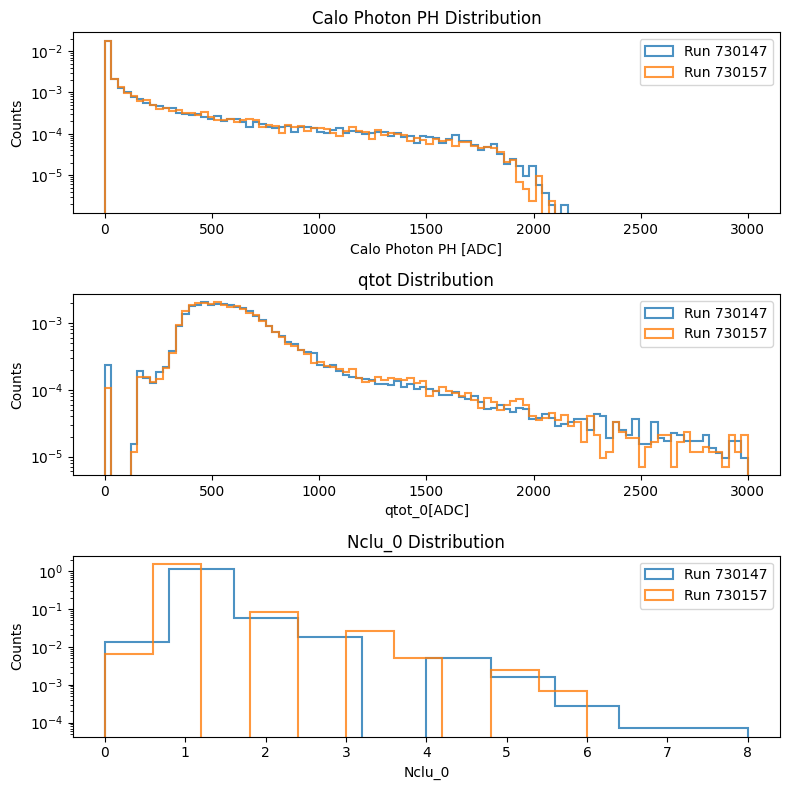

In [37]:
run_list = [730147,730157]

fig,ax = plt.subplots(3,figsize=(8, 8)) 
for run_number in run_list:
    x1, y1, x2, y2, x3, y3, xcry, ycry, ph_calo_photon, ph_cherry1, \
    theta_x_in, theta_y_in, theta_x_out, theta_y_out, tm, qtot, nclu, info_plus = file_loader(run_number)

    ax[0].hist(ph_calo_photon[ph_cherry1>th_cherry1],bins =100 ,range = (0,3000), label =f'Run {run_number}',density= True, **opt_hist)

    ax[1].hist(qtot[:,0][ph_cherry1>th_cherry1],bins =100 ,range = (0,3000), label =f'Run {run_number}',density= True, **opt_hist)
    
    ax[2].hist(nclu[:,0][ph_cherry1>th_cherry1], label =f'Run {run_number}',density= True, **opt_hist)
    print(f'{run_number} -- N spill: {info_plus[:,0][-1]} -- events: {len(ph_calo_photon)} -- evs/spill: {len(ph_calo_photon)/info_plus[:,0][-1]:.0f}')
ax[0].set_xlabel('Calo Photon PH [ADC]')
ax[0].set_ylabel('Counts')
ax[0].set_title('Calo Photon PH Distribution')
ax[0].legend()
ax[0].set_yscale('log')
ax[1].set_xlabel('qtot_0[ADC]')
ax[1].set_ylabel('Counts')
ax[1].set_title('qtot Distribution')
ax[1].legend()
ax[1].set_yscale('log')
ax[2].set_xlabel('Nclu_0')
ax[2].set_ylabel('Counts')
ax[2].set_title('Nclu_0 Distribution')
ax[2].legend()
ax[2].set_yscale('log')
plt.tight_layout()
plt.show()

## code for a scan (to be tested )

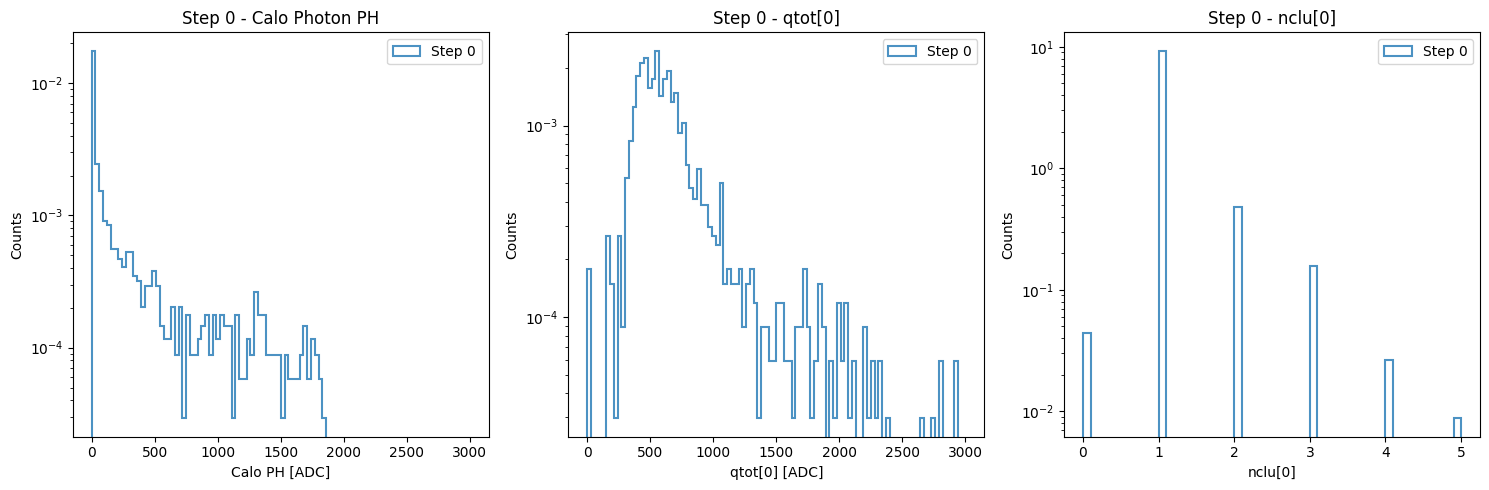

In [39]:
scan_number = 730158

# Caricamento dei dati (assumendo 1 solo run)
x1, y1, x2, y2, x3, y3, xcry, ycry, ph_calo_photon, ph_cherry1, \
theta_x_in, theta_y_in, theta_x_out, theta_y_out, tm, qtot, nclu, info_plus = file_loader(scan_number)

unique_steps = np.unique(info_plus[:, 1])
n_steps = len(unique_steps)
fig, axs = plt.subplots(n_steps, 3, figsize=(15, 5 * n_steps))

# Se c'è un solo step, axs avrà forma (3,) anziché (n_steps, 3), quindi forziamo la forma
if n_steps == 1:
    axs = axs.reshape(1, 3)

for i, step in enumerate(unique_steps):
    mask = (ph_cherry1 > th_cherry1) & (info_plus[:, 1] == step)

    if np.sum(mask) == 0:
        continue

    axs[i, 0].hist(ph_calo_photon[mask], bins=100, range=(0, 3000), label=f'Step {step}', density=True, **opt_hist)
    axs[i, 1].hist(qtot[:, 0][mask], bins=100, range=(0, 3000), label=f'Step {step}', density=True, **opt_hist)
    axs[i, 2].hist(nclu[:, 0][mask], bins=50, label=f'Step {step}', density=True, **opt_hist)

    axs[i, 0].set_title(f'Step {step} - Calo Photon PH')
    axs[i, 1].set_title(f'Step {step} - qtot[0]')
    axs[i, 2].set_title(f'Step {step} - nclu[0]')

    for j in range(3):
        axs[i, j].set_yscale('log')
        axs[i, j].legend()
        axs[i, j].set_xlabel(['Calo PH [ADC]', 'qtot[0] [ADC]', 'nclu[0]'][j])
        axs[i, j].set_ylabel('Counts')

plt.tight_layout()
plt.show()
